
The primary purpose of this file is to handle the rows in the error dataset ('the_pile.csv') after cleaning done in data_preprocess_01.ipynb. This file contains 464481 entries (1.6% of the original data). 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

To begin, let's read in the in the csv file with rows containing missing values. We will also need to read in the liquor_stores data as well.

In [2]:
the_pile = pd.read_csv('the_pile.csv')

/tmp/ipykernel_32215/3103210344.py:1: DtypeWarning: Columns (4,5,7,9,14) have mixed types. Specify dtype option on import or set low_memory=False.
  the_pile = pd.read_csv('the_pile.csv')


In [3]:
liquor_stores = pd.read_csv('Iowa_Liquor_Stores.csv')
liquor_stores = pd.read_csv('Iowa_Liquor_Stores.csv')
liquor_stores = liquor_stores.drop(['Store Status', 'Report Date'], axis=1)
liquor_stores.rename(columns={'Store Address': 'Store Location'}, inplace=True)
liquor_stores.rename(columns={'Store': 'Store Number'}, inplace=True)
liquor_stores.rename(columns={'Name': 'Store Name'}, inplace=True)
liquor_stores.head()

,Store Number,Store Name,Address,City,State,Zip Code,Store Location
0,10261,AVENUE G STORE / COUNCIL BLUFFS,1602 AVENUE G,COUNCIL BLUFFS,IA,51501,POINT (-95.868007008 41.268345002)
1,4191,FAREWAY STORES #995 / PELLA,2010 WASHINGTON ST,PELLA,IA,50219,POINT (-92.941820991 41.413265006)
2,5268,THE DEPOT ATKINS,"188, PARKRIDGE RD",ATKINS,IA,52206,POINT (-91.862706026 41.992304983)
3,5929,D&T'S / ODEBOLT,417 1ST ST,ODEBOLT,IA,51458,POINT (-95.255976028 42.313622014)
4,6150,THE DEPOT GILMAN,102 S. ELM ST.,GILMAN,IA,50106,POINT (-92.785956987 41.879548017)


Let's first check to see which columns contain NA values. 

In [4]:
print(the_pile.columns[the_pile.isna().any()])

Index(['Address', 'City', 'Zip Code', 'Store Location', 'County Number',
       'County', 'Category', 'Category Name', 'Vendor Number', 'Vendor Name',
       'State Bottle Cost', 'State Bottle Retail', 'Sale (Dollars)'],
      dtype='object')


It will be useful to see which rows contain only 1 NA value and no other NA values, so that we can focus our efforts. 

In [5]:
print('Rows only missing Address:')
print(len(the_pile[the_pile['Address'].isnull() & the_pile.drop('Address', axis=1).notnull().all(axis=1)]))
print('Rows only missing City:')
print(len(the_pile[the_pile['City'].isnull() & the_pile.drop('City', axis=1).notnull().all(axis=1)]))
print('Rows only missing Store Location:')
print(len(the_pile[the_pile['Store Location'].isnull() & the_pile.drop('Store Location', axis=1).notnull().all(axis=1)]))
print('Rows only missing Category Name:')
print(len(the_pile[the_pile['Category Name'].isnull() & the_pile.drop('Category Name', axis=1).notnull().all(axis=1)]))
print('Rows only missing Sale Data:')
print(len(the_pile[the_pile['Sale (Dollars)'].isnull() & the_pile.drop('Sale (Dollars)', axis=1).notnull().all(axis=1)]))


Rows only missing Address:
1
Rows only missing City:
0
Rows only missing Store Location:
324685
Rows only missing Category Name:
7169
Rows only missing Sale Data:
0


As we can see, the vast majority of rows missing only value 1 are only missing geodata. These rows also account for nearly 70% of our missing data, so making progress here will be key. We will first separate those rows containing only na values in the 'Store Location' column like we did previously.

In [6]:
#separating rows with Na only in the store location column
nan_location_df = the_pile[the_pile['Store Location'].isnull() & the_pile.drop('Store Location', axis=1).notnull().all(axis=1)]

In [7]:
print(nan_location_df.columns[nan_location_df.isna().any()])

Index(['Store Location'], dtype='object')


In [8]:
print(len(nan_location_df))

324685


Now, let's take a closer look at this section of data.

In [9]:
nan_location_df['Store Number'].value_counts()

Store Number
2560    12421
2502    12145
2625    11705
2620    10213
2500    10159
        ...  
5841        1
5409        1
5829        1
5358        1
5585        1
Name: count, Length: 450, dtype: int64

In [10]:
nan_location_df['Address'].value_counts()

Address
3600 BUSINESS HWY 151 EAST    12421
410 NORTH ANKENY BLVD         12145
3301 W KIMBERLY RD            11705
7101 UNIVERSITY AVE           10213
3800 W LINCOLN WAY            10159
                              ...  
65, WILLIAMS BLVD                 1
405 4TH AVENUE                    1
710 S PINE ST                     1
1995 SE UNIVERSITY                1
308, W MISSION                    1
Name: count, Length: 465, dtype: int64

In [11]:
na_location_data = nan_location_df[['Address']].copy()

nan_loc_data = na_location_data.value_counts()
nan_loc_data.to_csv('address_of_missing_geodata.csv', sep= '\t')

In [12]:
na_store_num_data = nan_location_df[['Store Number']].copy()

nan_store_data = na_store_num_data.value_counts()
nan_store_data.to_csv('Store_Number_of_missing_geodata.csv', sep= '\t')

Here is the top 10 of the counts of the 'Addresses' where Store Location is empty:

Address	count \
3600 BUSINESS HWY 151 EAST	12421 \
410 NORTH ANKENY BLVD	12145 \
3301 W KIMBERLY RD	11705 \
7101 UNIVERSITY AVE	10213 \
3800 W LINCOLN WAY	10159 \
2126 KIMBALL AVE	9549 \
3500 DODGE ST	9546 \
3221 SE 14TH ST	8780 \
910 N JEFFERSON	6781 

And here is the top 10 of the counts of the 'Store number' where Store Location is Empty:

2560	12421 \
2502	12145 \
2625	11705 \
2620	10213 \
2500	10159 \
2643	9549 \
2524	9546 \
2528	8780 \
2513	7480 

I have a sneaking suspicion that these Store Numbers and Addresses correspond to the same places. Let us investigate further. To do this, we will start by reading in the yearly liquor data frames.

In [13]:
import glob

#find files beginning with Iowa_Liquor_Data
files_list = glob.glob('Iowa_Liquor_Data*.csv')

#read in matching files into a dictionary
data_frames = {file: pd.read_csv(file) for file in files_list}

For every store number in our nan_location df, we iterate through the yearly sales data and get the unique addresses, zip codes, and cities corresponding to it, storing the results in a new dataframe. 

In [14]:
#initialize dictionary to store 'Store Number' sets
store_set_dict = {}

#count store nums in liquor_stores data
fillable_count = 0

#count store nums not in liquor_stores data
unfillable_count = 0
#list to store store nums not in data
unfillable_store_numbers = []


#iterate through each store num in nan_location_df
for store_number in nan_location_df['Store Number'].unique():

    #initialize sets to store unique addresses, store names, zip codes, and unique cities for the current store number
    unique_addresses = set()
    unique_zip_codes = set()
    unique_cities = set()
    unique_counties = set()

    if store_number in liquor_stores['Store Number'].values:
        #print(f'store number: {store_number} detected in liquor data')
        fillable_count +=1

 
        
        #iterate through dataframes by year
        for year, df in data_frames.items():
            #filter dataframe by store number 
            filtered_df = df[df['Store Number'] == store_number]
            
            #get column values corresponding to store number
            filtered_addresses = filtered_df['Address']
            filtered_zip_codes = filtered_df['Zip Code']
            filtered_cities = filtered_df['City']
            filtered_counties = filtered_df['County']

            #update set to only keep unique values
            unique_addresses.update(filtered_addresses)  
            unique_zip_codes.update(filtered_zip_codes)  
            unique_cities.update(filtered_cities)
            unique_counties.update(filtered_counties)  
    else:
        #print(f'store number: {store_number} not detected in liquor data')
        unfillable_count +=1
        unfillable_store_numbers.append(store_number)
     
    #store the store number:unique val pairs in dictionary
    store_set_dict[store_number] = {
        'Unique Addresses': unique_addresses,
        'Unique Zip Codes': unique_zip_codes,
        'Unique Cities': unique_cities,
        'Unique Counties': unique_counties
    }


#list to store rows for the final df
rows = []

#iteratively parse dictionary items to create rows for the final df
for store_number, values in store_set_dict.items():
    #combine unique values into comma-separated strings
    combined_addresses = ', '.join(values['Unique Addresses'])
    combined_zip_codes = ', '.join(map(str, values['Unique Zip Codes']))  #zip must be converted to string
    combined_cities = ', '.join(values['Unique Cities'])
    combined_counties = ', '.join(values['Unique Counties'])
    
    #append rows with store number values
    rows.append({
        'Store Number': store_number,
        'Unique Addresses': combined_addresses,
        'Unique Zip Codes': combined_zip_codes,
        'Unique Cities': combined_cities,
        'Unique Counties': combined_counties,
    })

#generate a final dataframe with results
final_df_of_unique_vals = pd.DataFrame(rows)

#get the value counts of 'Store Number' in nan_location_df and sort by frequency
sorted_store_numbers = nan_location_df['Store Number'].value_counts().index

#reorder the final_df based on frequencies
final_df_of_unique_vals = final_df_of_unique_vals.set_index('Store Number').loc[sorted_store_numbers].reset_index()
#remove entries corresponding to unfillable store numbers
final_df_of_unique_vals = final_df_of_unique_vals[~final_df_of_unique_vals['Store Number'].isin(unfillable_store_numbers)]

print(f'Total fillable store numbers: {fillable_count}')
print(f'Total unfillable store numbers: {unfillable_count}')


Total fillable store numbers: 419
Total unfillable store numbers: 31


In [15]:
#We have to remove rows that don't have a corresponding store number in liquor_stores
nan_location_df = nan_location_df[~nan_location_df['Store Number'].isin(unfillable_store_numbers)]

Great! Now we have a dataframe that we can inspect manually to identify potential issues. 

One important note is that there are diminishing returns in the sums of missing values for every store number we fix, as demonstrated in the following visualization.

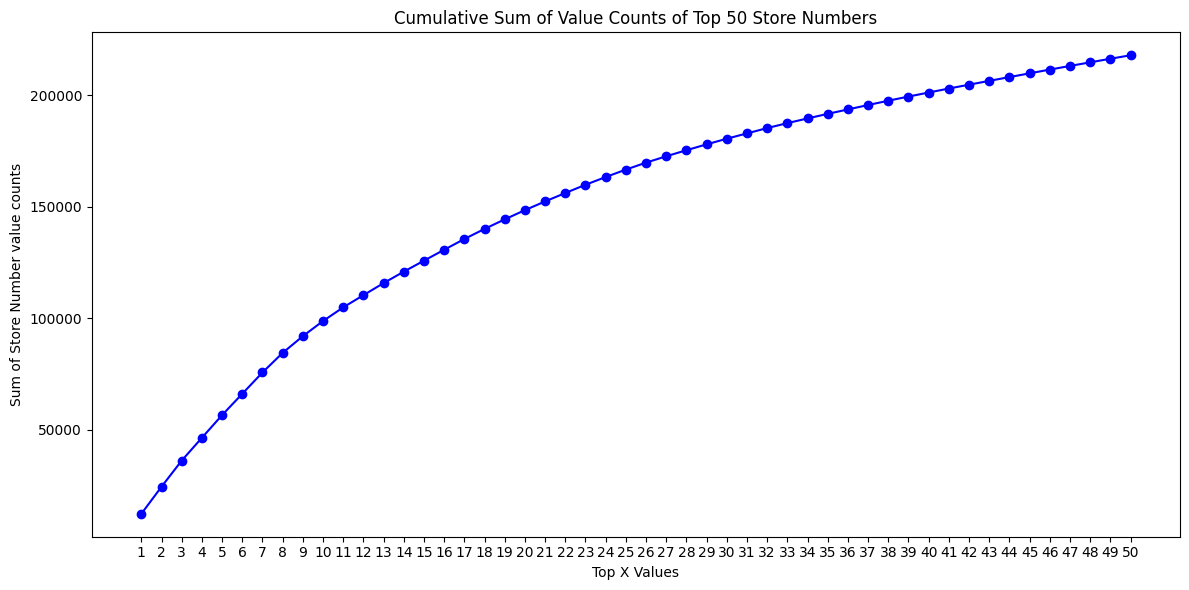

In [16]:

#variable to define the maximum number of top occurrences to consider
top_X_sums_to_calc = 50 

#initialize lists to store top X value counts and their cumulative sums
top_X_values = []
cumulative_sums = []

#loop calculate cumulative sums for different top X values
for num in range(1, top_X_sums_to_calc + 1):
    #get the value counts of store number column
    store_number_val_counts = nan_location_df['Store Number'].value_counts()
    
    #get the sum of the top X occurrences
    sum_top_X = store_number_val_counts.head(num).sum()
    
    #append top X and its cumulative sum to the lists
    top_X_values.append(num)
    cumulative_sums.append(sum_top_X)

#plot line chart for cummulative sums
plt.figure(figsize=(12, 6))
plt.plot(top_X_values, cumulative_sums, marker='o', linestyle='-', color='b')
plt.xlabel('Top X Values')
plt.ylabel('Sum of Store Number value counts')
plt.title('Cumulative Sum of Value Counts of Top 50 Store Numbers')

# Set X-axis ticks and labels
plt.xticks(range(1, top_X_sums_to_calc + 1))

# Show the plot
plt.tight_layout()
plt.show()

In [17]:
#define the number of top occurrences to consider
top_X = 50

#get value counts of Store Number columns and sum them
store_num_val_counts = nan_location_df['Store Number'].value_counts()
sum_top_X = store_num_val_counts.head(top_X).sum()

print(f"Sum of values counts top {top_X} occurrences: {sum_top_X}")
print(f"This corresponds to {sum_top_X/len(the_pile) * 100}% of the remaining missing values. ")

top_store_nums = nan_location_df['Store Number'].value_counts().head(top_X).index

# Filtering nan_location_df to keep rows where the address appears in the top X
nan_location_df = nan_location_df[nan_location_df['Store Number'].isin(top_store_nums)]


#filter df to keep rows with store numbers in the top 50
filtered_final_df = final_df_of_unique_vals[final_df_of_unique_vals['Store Number'].isin(top_store_nums)]

Sum of values counts top 50 occurrences: 217838
This corresponds to 46.86290581080412% of the remaining missing values. 


What's more is that the the number of distinct store numbers with missing geodata is 419, and since I am going to be manually inspecting these store numbers for discrepancies, that would take an innordiate amount of time. Therefore, we will limit our focus to fixing counts in the top 50.

Let's go ahead and grab those rows from final_df for one more round of processing

In [18]:
filtered_final_df.to_csv('filtered_location_na.csv', sep = '\t')

After visual inspection, there are only a handful that may be problematic. Here are those entries: 

Store Number	Unique Addresses	                        Unique Zip Codes	Unique Cities	Unique Counties 

13	2535	1700 VALLEY WEST DR., 1700 VALLEY WEST DR	    50265, 50266	    WEST DES MOINES	    POLK 

14	2522	1902 PEORIA AVE, HWY 9 & 71, 1902 PEORIA AVENUE	51360	            SPIRIT LAKE	        DICKINSON
  
17	2539	HIGHWAY 65 SOUTH, 640 S. OAK	                50126	            IOWA FALLS	        HARDIN 

35	2556	1033 CENTRAL AVENUE, 1221 E CENTRAL AVENUE, 2608 E. CENTRAL AVENUE	51334	ESTHERVILLE	EMMET

50	4084	3205 NORTH ANKENY BLVD	                        50021, 50023	     ANKENY	            POLK



These rows either have a multiple zip codes or multiple addresses and cannot be trusted. So we will remove rows where store num is 2535, 2522, 2539, 2556, and 4084

In [19]:
store_numbers_to_remove = [2535, 2522, 2539, 2556, 4084]

#remove rows with specified store numbers
nan_location_df = nan_location_df[~nan_location_df['Store Number'].isin(store_numbers_to_remove)]


In [20]:
len(nan_location_df)

199660

Now we can go ahead and fill that geodata

In [22]:
#merge store location information from liquor_stores into nan_location_df
nan_location_df = nan_location_df.merge(liquor_stores[['Store Number', 'Store Location']], on='Store Number', how='left')
nan_location_df.drop(columns='Unnamed: 0', inplace=True)

#replace values in 'Store Location_x' with values in 'Store Location_y'
nan_location_df['Store Location_x'] = nan_location_df['Store Location_y']

#drop 'Store Location_y' column
nan_location_df.drop(columns='Store Location_y', inplace=True)

#rename column
nan_location_df.rename(columns={'Store Location_x': 'Store Location'}, inplace=True)

In [23]:
nan_location_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199660 entries, 0 to 199659
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Date                   199660 non-null  object 
 1   Store Number           199660 non-null  int64  
 2   Store Name             199660 non-null  object 
 3   Address                199660 non-null  object 
 4   City                   199660 non-null  object 
 5   Zip Code               199660 non-null  float64
 6   Store Location         199660 non-null  object 
 7   County Number          199660 non-null  float64
 8   County                 199660 non-null  object 
 9   Category               199660 non-null  float64
 10  Category Name          199660 non-null  object 
 11  Vendor Number          199660 non-null  float64
 12  Vendor Name            199660 non-null  object 
 13  Item Number            199660 non-null  object 
 14  Item Description       199660 non-nu

In [24]:
nan_location_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199660 entries, 0 to 199659
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Date                   199660 non-null  object 
 1   Store Number           199660 non-null  int64  
 2   Store Name             199660 non-null  object 
 3   Address                199660 non-null  object 
 4   City                   199660 non-null  object 
 5   Zip Code               199660 non-null  float64
 6   Store Location         199660 non-null  object 
 7   County Number          199660 non-null  float64
 8   County                 199660 non-null  object 
 9   Category               199660 non-null  float64
 10  Category Name          199660 non-null  object 
 11  Vendor Number          199660 non-null  float64
 12  Vendor Name            199660 non-null  object 
 13  Item Number            199660 non-null  object 
 14  Item Description       199660 non-nu

Before we merge the location data we filled, there is a slight problem. Simply converting the 'Date' column in both the original, clean datasets, and the nan_location_df and merging them together results in mixed date datatypes. We do NOT want this so we need to preprocess both. We also need to conver the 'Date' column into a format suitable to populate a SQL database with. 

In [25]:
for name, df in data_frames.items():
    print(f"Processing {name}...")
    
    #attempt to convert date column to date type
    try:
        #NOTE errors = 'coerce' seems to be crucial here
        #Converting to datetime is required before the converting to SQL friendly format
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df['Date'] = df['Date'].dt.strftime('%Y-%m-%d') #SQL friendly format
        print(f"Conversion successful in {name}")
    except ValueError as e:
        print(f"Error converting 'Date' column in {name}: {e}")
 

#checking the data column types after conversion attempt
for name, df in data_frames.items():
    print(f"DataFrame: {name}")
    print(df['Date'].dtypes)

Processing Iowa_Liquor_Data_2018.csv...
Conversion successful in Iowa_Liquor_Data_2018.csv
Processing Iowa_Liquor_Data_2016.csv...
Conversion successful in Iowa_Liquor_Data_2016.csv
Processing Iowa_Liquor_Data_2022.csv...
Conversion successful in Iowa_Liquor_Data_2022.csv
Processing Iowa_Liquor_Data_2014.csv...
Conversion successful in Iowa_Liquor_Data_2014.csv
Processing Iowa_Liquor_Data_2012.csv...
Conversion successful in Iowa_Liquor_Data_2012.csv
Processing Iowa_Liquor_Data_2017.csv...
Conversion successful in Iowa_Liquor_Data_2017.csv
Processing Iowa_Liquor_Data_2019.csv...
Conversion successful in Iowa_Liquor_Data_2019.csv
Processing Iowa_Liquor_Data_2020.csv...
Conversion successful in Iowa_Liquor_Data_2020.csv
Processing Iowa_Liquor_Data_2013.csv...
Conversion successful in Iowa_Liquor_Data_2013.csv
Processing Iowa_Liquor_Data_2021.csv...
Conversion successful in Iowa_Liquor_Data_2021.csv
Processing Iowa_Liquor_Data_2015.csv...
Conversion successful in Iowa_Liquor_Data_2015.csv

In order to merge the nan_location_df with the clean datasets, we have to get the indicies corresponding to each year, prior to merging. Then we convert to a SQL friendly format and merge the datasets using the gathered indicies.

In [29]:
#convert to datetime in order to gather yearly indicies
nan_location_df['Date'] = pd.to_datetime(nan_location_df['Date'], errors='coerce')
#store indices corresponding to each year before merging
indices_by_year = {}
for year in nan_location_df['Date'].dt.year.unique():
    indices_by_year[year] = nan_location_df[nan_location_df['Date'].dt.year == year].index

#convert date column to SQL friendly format
nan_location_df['Date'] = nan_location_df['Date'].dt.strftime('%Y-%m-%d')

In [33]:
#iterate through data_frames dictionary
for file, df in data_frames.items():
    #get year from file naem
    year = int(file.split('_')[-1].split('.')[0])
    
    #retrieve indicies for year in nan_location_df
    relevant_indices = indices_by_year.get(year, [])
    
    #retrieve indicies corresponding to yearly data
    nan_location_yearly = nan_location_df.loc[relevant_indices]

    #merge relevant yearly data together
    concatenated_df = pd.concat([df, nan_location_yearly], ignore_index=True)
    
    #output to a new CSV file
    new_file_name = f"V2_{file}"
    concatenated_df.to_csv(new_file_name, index=False)
    
    print(f"Concatenated data for {year} into {new_file_name}")
    print(f"Length of original file {file}: {len(df)} | Length of concatenated file {new_file_name}: {len(concatenated_df)}")

Concatenated data for 2018 into V2_Iowa_Liquor_Data_2018.csv
Length of original file Iowa_Liquor_Data_2018.csv: 2347300 | Length of concatenated file V2_Iowa_Liquor_Data_2018.csv: 2350331
Concatenated data for 2016 into V2_Iowa_Liquor_Data_2016.csv
Length of original file Iowa_Liquor_Data_2016.csv: 2189783 | Length of concatenated file V2_Iowa_Liquor_Data_2016.csv: 2200180
Concatenated data for 2022 into V2_Iowa_Liquor_Data_2022.csv
Length of original file Iowa_Liquor_Data_2022.csv: 2398105 | Length of concatenated file V2_Iowa_Liquor_Data_2022.csv: 2498801
Concatenated data for 2014 into V2_Iowa_Liquor_Data_2014.csv
Length of original file Iowa_Liquor_Data_2014.csv: 2076720 | Length of concatenated file V2_Iowa_Liquor_Data_2014.csv: 2090396
Concatenated data for 2012 into V2_Iowa_Liquor_Data_2012.csv
Length of original file Iowa_Liquor_Data_2012.csv: 2043287 | Length of concatenated file V2_Iowa_Liquor_Data_2012.csv: 2066511
Concatenated data for 2017 into V2_Iowa_Liquor_Data_2017.csv

With that done, the remaining NA values account for less than 1% of the total data. If time allows, I will revist the NA values, but for the time being I will forge ahead

In [ ]:
rows_remaining = len(the_pile) - len(nan_location_df)
percent_na_left = (rows_remaining / 27489743) * 100
print(percent_na_left)